In [2]:
import data
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

tickers = assets = ["BTCUSDT", "DOGEUSDT", "ETHUSDT", "SOLUSDT", "XRPUSDT"]
dfs = [
    data.load_asset(asset, sampling="1d") for asset in assets
]
for df in dfs:
    df['Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)   
dfs = [
    df[(df.index >= '2022-01-01') & (df.index <= '2025-01-01')] for df in dfs
]

START_DATE = '2024-06-13'

OrderedDict([('BTCUSDT', 0.0), ('DOGEUSDT', 0.0), ('ETHUSDT', 0.0), ('SOLUSDT', 0.0), ('XRPUSDT', 1.0)])


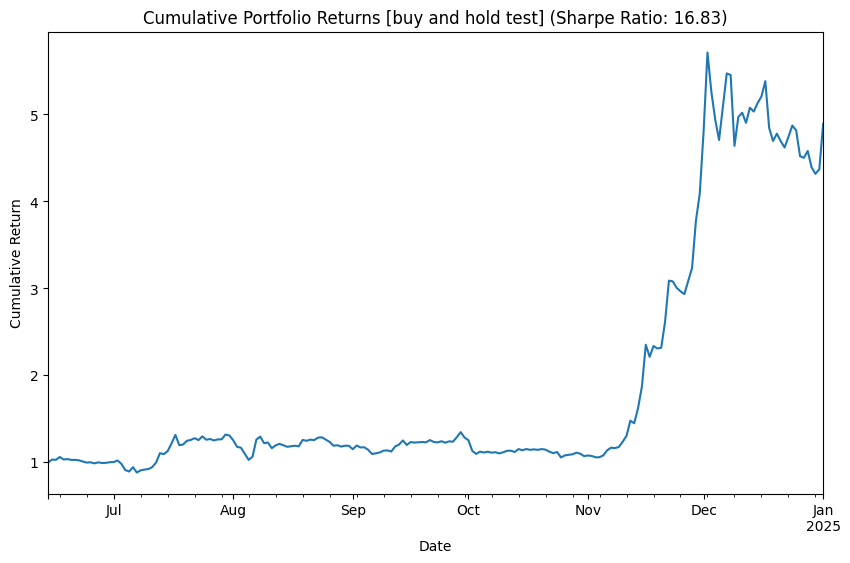

In [3]:
from pypfopt import EfficientFrontier, risk_models, expected_returns

test_dfs = [
    df[(df.index > START_DATE)] for df in dfs
]


returns = [df["Return"] for df in test_dfs]
opens = pd.concat([df["Open"] for df in test_dfs], axis=1)
opens.columns = tickers
mean_returns = expected_returns.mean_historical_return(opens, frequency=365)
cov_matrix = risk_models.sample_cov(opens)

# Optimize for maximum Sharpe ratio
ef = EfficientFrontier(mean_returns, cov_matrix)
weights = ef.max_sharpe(risk_free_rate=0.001)
hold_cleaned_weights = ef.clean_weights()

print(hold_cleaned_weights)


test_hold_portfolio_weights = pd.DataFrame(columns=[*tickers, 'Return'])
start_date = pd.Timestamp(START_DATE)
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    daily_returns = pd.DataFrame(
        {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
        index=[current_date]
    ).loc[current_date]
    portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)

    test_hold_portfolio_weights.loc[current_date] = 0.0
    test_hold_portfolio_weights.loc[current_date] = [*hold_cleaned_weights.values(), portfolio_return]

portfolio_cumulative_returns = (1 + test_hold_portfolio_weights['Return']).cumprod()
portfolio_annualized_return = portfolio_cumulative_returns.iloc[-1]**(365 / len(test_hold_portfolio_weights)) - 1
portfolio_annualized_volatility = test_hold_portfolio_weights['Return'].std() * np.sqrt(365)
sharpe_ratio = portfolio_annualized_return / portfolio_annualized_volatility
# sharpe_ratio = test_hold_portfolio_weights['Return'].mean() / test_hold_portfolio_weights['Return'].std() * np.sqrt(365)

portfolio_cumulative_returns.plot(figsize=(10, 6), title=f"Cumulative Portfolio Returns [buy and hold test] (Sharpe Ratio: {sharpe_ratio:.2f})")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

OrderedDict([('BTCUSDT', 0.0), ('DOGEUSDT', 0.0), ('ETHUSDT', 0.0), ('SOLUSDT', 1.0), ('XRPUSDT', 0.0)])


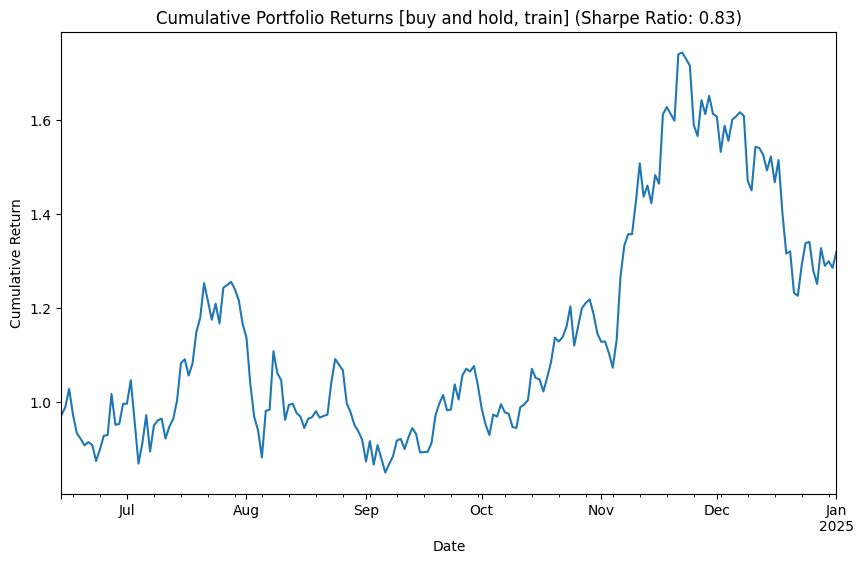

In [4]:
from pypfopt import EfficientFrontier, risk_models, expected_returns

train_dfs = [
    df[(df.index < START_DATE)] for df in dfs
]


returns = [df["Return"] for df in train_dfs]
opens = pd.concat([df["Open"] for df in train_dfs], axis=1)
opens.columns = tickers
mean_returns = expected_returns.mean_historical_return(opens.iloc[-365:], frequency=365)
cov_matrix = risk_models.sample_cov(opens)

# Optimize for maximum Sharpe ratio
ef = EfficientFrontier(mean_returns, cov_matrix)
weights = ef.max_sharpe(risk_free_rate=0.001)
hold_cleaned_weights = ef.clean_weights()

print(hold_cleaned_weights)


hold_portfolio_weights = pd.DataFrame(columns=[*tickers, 'Return'])
start_date = pd.Timestamp(START_DATE)
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    daily_returns = pd.DataFrame(
        {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
        index=[current_date]
    ).loc[current_date]
    portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)

    hold_portfolio_weights.loc[current_date] = 0.0
    hold_portfolio_weights.loc[current_date] = [*hold_cleaned_weights.values(), portfolio_return]

portfolio_cumulative_returns = (1 + hold_portfolio_weights['Return']).cumprod()
portfolio_annualized_return = portfolio_cumulative_returns.iloc[-1]**(365 / len(hold_portfolio_weights)) - 1
portfolio_annualized_volatility = hold_portfolio_weights['Return'].std() * np.sqrt(365)
sharpe_ratio = portfolio_annualized_return / portfolio_annualized_volatility
# sharpe_ratio = hold_portfolio_weights['Return'].mean() / hold_portfolio_weights['Return'].std() * np.sqrt(365)

portfolio_cumulative_returns.plot(figsize=(10, 6), title=f"Cumulative Portfolio Returns [buy and hold, train] (Sharpe Ratio: {sharpe_ratio:.2f})")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

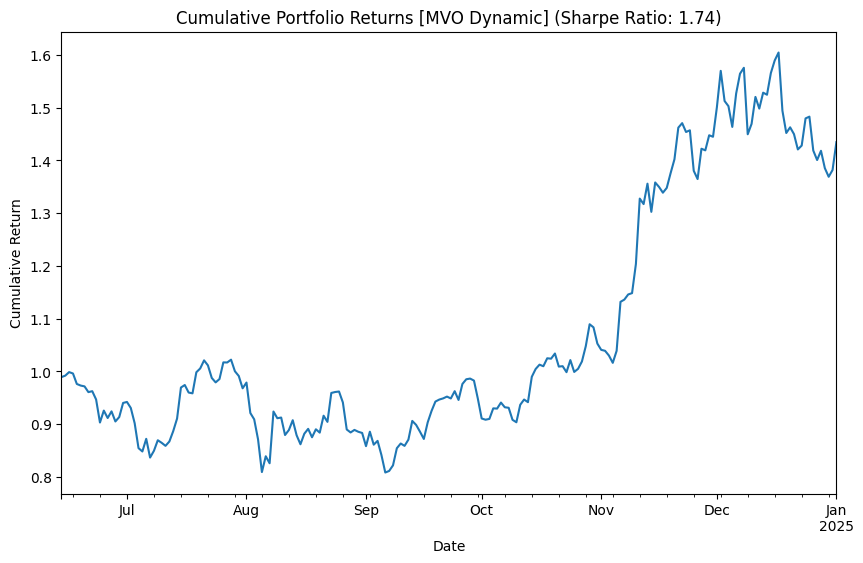

In [5]:
portfolio_weights = pd.DataFrame(columns=[*tickers, 'Return'])

# Define the start date
start_date = pd.Timestamp(START_DATE)

# Iterate through each day after March 1, 2024
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    # Filter data up to the current date
    opens = pd.concat([df["Open"] for df in dfs], axis=1)
    opens.columns = tickers
    data_up_to_today = opens.loc[:current_date]

    # Calculate expected returns and covariance matrix using the latest data
    mean_returns = expected_returns.mean_historical_return(data_up_to_today, frequency=365)
    cov_matrix = risk_models.sample_cov(data_up_to_today)

    # Optimize for maximum Sharpe ratio
    ef = EfficientFrontier(mean_returns, cov_matrix)
    weights = ef.max_sharpe(risk_free_rate=0.001)
    cleaned_weights = ef.clean_weights()

    # Get returns for the current day (next day's returns based on today's weights)
    daily_returns = pd.DataFrame(
        {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
        index=[current_date]
    ).loc[current_date]

    # Calculate portfolio return using today's weights
    portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)

    portfolio_weights.loc[current_date] = 0.0
    portfolio_weights.loc[current_date] = [*cleaned_weights.values(), portfolio_return]

# Calculate the Sharpe ratio using the returns data
portfolio_cumulative_returns = (1 + portfolio_weights['Return']).cumprod()
portfolio_annualized_return = portfolio_cumulative_returns.iloc[-1]**(365 / len(portfolio_weights)) - 1
portfolio_annualized_volatility = portfolio_weights['Return'].std() * np.sqrt(365)
sharpe_ratio = portfolio_annualized_return / portfolio_annualized_volatility
# sharpe_ratio = portfolio_weights['Return'].mean() / portfolio_weights['Return'].std() * np.sqrt(365)

portfolio_cumulative_returns.plot(figsize=(10, 6), title=f"Cumulative Portfolio Returns [MVO Dynamic] (Sharpe Ratio: {sharpe_ratio:.2f})")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -1
Using -1
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -1
Using -1
Using -1
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -1
Using -1
Using -1
Using -0.5
Using -0.5
Using -1
Using -1
Using -1
Using -0.5
Using -0.5
Using -1
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -0.5
Using -1
Using -1
Using -1
Using -0.5
Using -0.5
Couldn't find 2024-10-26
Using -0.5
Using -0.5


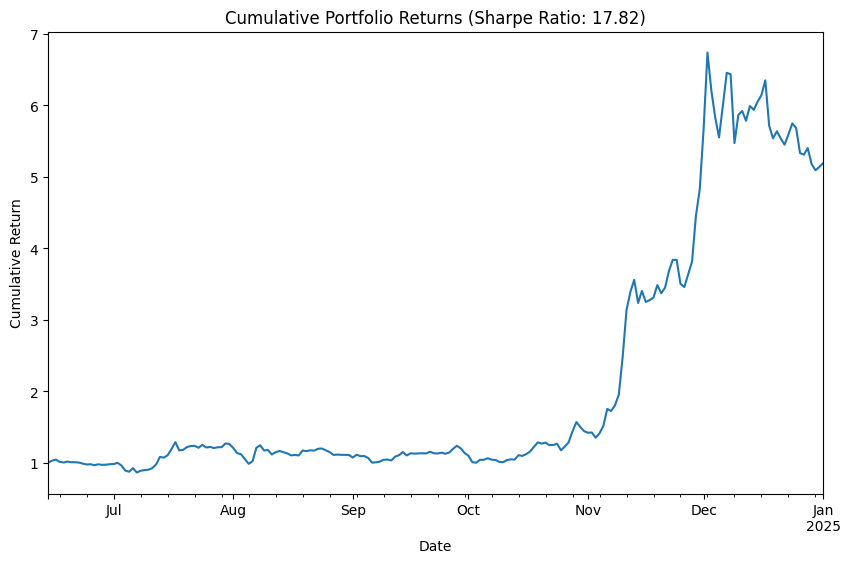

In [12]:
predictions_dfs = [
    pd.read_csv(f'./-for_optimization-/{tick}_Close_predictions.csv')[["Date", "Predicted"]].set_index('Date') for tick in tickers
]

Clopred_portfolio_weights = pd.DataFrame(columns=[*tickers, 'Return'])
alpha = 0.5
beta = 1
window = 30

# Define the start date
start_date = pd.Timestamp(START_DATE)
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    # Filter data up to the current date
    opens = pd.concat([df["Open"] for df in dfs], axis=1)
    opens.columns = tickers
    data_up_to_today = opens.loc[:current_date]
    if len(data_up_to_today) > window:
        data_up_to_today = data_up_to_today.iloc[-window:]
    try:
        predictions = np.array([
            p_df.loc[str(current_date.date())].values for p_df in predictions_dfs
        ]).flatten()

        mean_prices = data_up_to_today.mean()
        enhanced_data = data_up_to_today.copy()
        for i in range(beta):
            enhanced_data.loc[f'{i}'] = (1 - alpha) * mean_prices + alpha * predictions

        # Calculate expected returns and covariance matrix using the latest data
        mean_returns = expected_returns.mean_historical_return(enhanced_data, frequency=365)
        cov_matrix = risk_models.sample_cov(enhanced_data)

        # Optimize for maximum Sharpe ratio
        ef = EfficientFrontier(mean_returns, cov_matrix)
        try:
            weights = ef.max_sharpe(risk_free_rate=0.001)
        except Exception:
            try:
                ef = EfficientFrontier(mean_returns, cov_matrix)
                weights = ef.max_sharpe(risk_free_rate=-0.5)
                print("Using -0.5")
            except Exception:
                ef = EfficientFrontier(mean_returns, cov_matrix)
                weights = ef.max_sharpe(risk_free_rate=-1)
                print("Using -1")
        cleaned_weights = ef.clean_weights()
    except KeyError:
        print("Couldn't find", str(current_date.date()))

    
    # Get returns for the current day (next day's returns based on today's weights)
    daily_returns = pd.DataFrame(
        {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
        index=[current_date]
    ).loc[current_date]

    # Calculate portfolio return using today's weights
    portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)

    Clopred_portfolio_weights.loc[current_date] = 0.0
    Clopred_portfolio_weights.loc[current_date] = [*cleaned_weights.values(), portfolio_return]

# Calculate the Sharpe ratio using the returns data
portfolio_cumulative_returns = (1 + Clopred_portfolio_weights['Return']).cumprod()
portfolio_annualized_return = portfolio_cumulative_returns.iloc[-1]**(365 / len(portfolio_weights)) - 1
portfolio_annualized_volatility = Clopred_portfolio_weights['Return'].std() * np.sqrt(365)
sharpe_ratio = portfolio_annualized_return / portfolio_annualized_volatility
# sharpe_ratio = Clopred_portfolio_weights['Return'].mean() / Clopred_portfolio_weights['Return'].std() * np.sqrt(365)

portfolio_cumulative_returns.plot(figsize=(10, 6), title=f"Cumulative Portfolio Returns (Sharpe Ratio: {sharpe_ratio:.2f})")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing weights
Not changing 

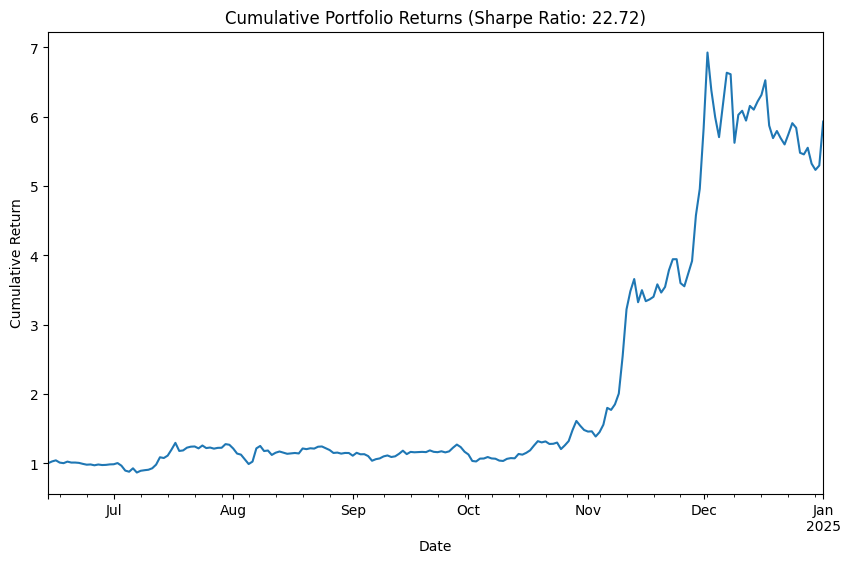

In [15]:
predictions_dfs = [
    pd.read_csv(f'./-for_optimization-/{tick}_Close_predictions.csv')[["Date", "Predicted"]].set_index('Date') for tick in tickers
]

Clopred_portfolio_weights = pd.DataFrame(columns=[*tickers, 'Return'])
alpha = 0.5
beta = 1
window = 30

# Define the start date
start_date = pd.Timestamp(START_DATE)
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    # Filter data up to the current date
    opens = pd.concat([df["Open"] for df in dfs], axis=1)
    opens.columns = tickers
    data_up_to_today = opens.loc[:current_date]
    if len(data_up_to_today) > window:
        data_up_to_today = data_up_to_today.iloc[-window:]
    try:
        predictions = np.array([
            p_df.loc[str(current_date.date())].values for p_df in predictions_dfs
        ]).flatten()

        mean_prices = data_up_to_today.mean()
        enhanced_data = data_up_to_today.copy()
        for i in range(beta):
            enhanced_data.loc[f'{i}'] = (1 - alpha) * mean_prices + alpha * predictions

        # Calculate expected returns and covariance matrix using the latest data
        mean_returns = expected_returns.mean_historical_return(enhanced_data, frequency=365)
        cov_matrix = risk_models.sample_cov(enhanced_data)

        # Optimize for maximum Sharpe ratio
        ef = EfficientFrontier(mean_returns, cov_matrix)
        try:
            weights = ef.max_sharpe(risk_free_rate=0.0001)
            cleaned_weights = ef.clean_weights()
        except Exception:
            print("Not changing weights")
            pass
    except KeyError:
        print("Couldn't find", str(current_date.date()))

    
    # Get returns for the current day (next day's returns based on today's weights)
    daily_returns = pd.DataFrame(
        {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
        index=[current_date]
    ).loc[current_date]

    # Calculate portfolio return using today's weights
    portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)

    Clopred_portfolio_weights.loc[current_date] = 0.0
    Clopred_portfolio_weights.loc[current_date] = [*cleaned_weights.values(), portfolio_return]

# Calculate the Sharpe ratio using the returns data
portfolio_cumulative_returns = (1 + Clopred_portfolio_weights['Return']).cumprod()
portfolio_annualized_return = portfolio_cumulative_returns.iloc[-1]**(365 / len(portfolio_weights)) - 1
portfolio_annualized_volatility = Clopred_portfolio_weights['Return'].std() * np.sqrt(365)
sharpe_ratio = portfolio_annualized_return / portfolio_annualized_volatility
# sharpe_ratio = Clopred_portfolio_weights['Return'].mean() / Clopred_portfolio_weights['Return'].std() * np.sqrt(365)

portfolio_cumulative_returns.plot(figsize=(10, 6), title=f"Cumulative Portfolio Returns (Sharpe Ratio: {sharpe_ratio:.2f})")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

Couldn't find 2024-10-26


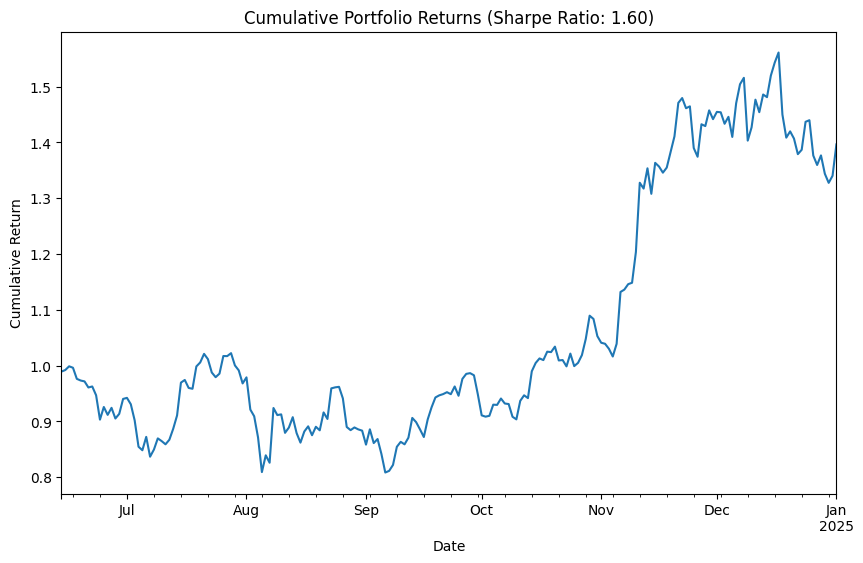

In [16]:
predictions_dfs = [
    pd.read_csv(f'./-for_optimization-/{tick}_MA_7_predictions.csv')[["Date", "Predicted"]].set_index('Date') for tick in tickers
]

Clomv_portfolio_weights = pd.DataFrame(columns=[*tickers, 'Return'])
alpha = 0.9
beta = 1
window = 10000

# Define the start date
start_date = pd.Timestamp(START_DATE)
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    # Filter data up to the current date
    opens = pd.concat([df["Open"] for df in dfs], axis=1)
    opens.columns = tickers
    data_up_to_today = opens.loc[:current_date]
    if len(data_up_to_today) > window:
        data_up_to_today = data_up_to_today.iloc[-window:]
    try:
        predictions = np.array([
            p_df.loc[str(current_date.date())].values for p_df in predictions_dfs
        ]).flatten()

        mean_prices = data_up_to_today.mean()
        enhanced_data = data_up_to_today.copy()
        for i in range(beta):
            enhanced_data.loc[f'{i}'] = (1 - alpha) * mean_prices + alpha * predictions

        # Calculate expected returns and covariance matrix using the latest data
        mean_returns = expected_returns.mean_historical_return(enhanced_data, frequency=365)
        cov_matrix = risk_models.sample_cov(enhanced_data)

        # Optimize for maximum Sharpe ratio
        ef = EfficientFrontier(mean_returns, cov_matrix)
        try:
            weights = ef.max_sharpe(risk_free_rate=0.0001)
            cleaned_weights = ef.clean_weights()
        except Exception:
            print("Using previous weights")
            pass
    except KeyError:
        print("Couldn't find", str(current_date.date()))

    
    # Get returns for the current day (next day's returns based on today's weights)
    daily_returns = pd.DataFrame(
        {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
        index=[current_date]
    ).loc[current_date]

    # Calculate portfolio return using today's weights
    portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)

    Clomv_portfolio_weights.loc[current_date] = 0.0
    Clomv_portfolio_weights.loc[current_date] = [*cleaned_weights.values(), portfolio_return]

# Calculate the Sharpe ratio using the returns data
portfolio_cumulative_returns = (1 + Clomv_portfolio_weights['Return']).cumprod()
portfolio_annualized_return = portfolio_cumulative_returns.iloc[-1]**(365 / len(portfolio_weights)) - 1
portfolio_annualized_volatility = Clomv_portfolio_weights['Return'].std() * np.sqrt(365)
sharpe_ratio = portfolio_annualized_return / portfolio_annualized_volatility
# sharpe_ratio = Clopred_portfolio_weights['Return'].mean() / Clopred_portfolio_weights['Return'].std() * np.sqrt(365)

portfolio_cumulative_returns.plot(figsize=(10, 6), title=f"Cumulative Portfolio Returns (Sharpe Ratio: {sharpe_ratio:.2f})")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previ

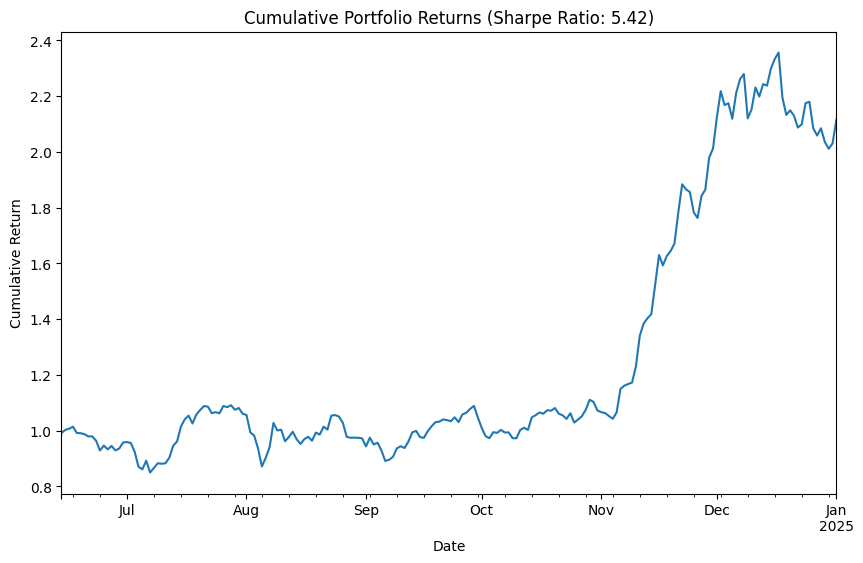

In [17]:
predictions_dfs = [
    pd.read_csv(f'./-for_optimization-/{tick}_Close_predictions.csv')[["Date", "Predicted"]].set_index('Date') for tick in tickers
]

Clopred_portfolio_weights = pd.DataFrame(columns=[*tickers, 'Return'])
alpha = 0.05
beta = 1
window = 10000

# Define the start date
start_date = pd.Timestamp(START_DATE)
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    # Filter data up to the current date
    opens = pd.concat([df["Open"] for df in dfs], axis=1)
    opens.columns = tickers
    data_up_to_today = opens.loc[:current_date]
    if len(data_up_to_today) > window:
        data_up_to_today = data_up_to_today.iloc[-window:]
    try:
        predictions = np.array([
            p_df.loc[str(current_date.date())].values for p_df in predictions_dfs
        ]).flatten()

        mean_prices = data_up_to_today.mean()
        enhanced_data = data_up_to_today.copy()
        for i in range(beta):
            enhanced_data.loc[f'{i}'] = (1 - alpha) * mean_prices + alpha * predictions

        # Calculate expected returns and covariance matrix using the latest data
        mean_returns = expected_returns.mean_historical_return(enhanced_data, frequency=365)
        cov_matrix = risk_models.sample_cov(enhanced_data)

        # Optimize for maximum Sharpe ratio
        ef = EfficientFrontier(mean_returns, cov_matrix)
        try:
            weights = ef.max_sharpe(risk_free_rate=0.0001)
            cleaned_weights = ef.clean_weights()
        except Exception:
            print("Using previous weights")
            pass
    except KeyError:
        print("Couldn't find", str(current_date.date()))

    
    # Get returns for the current day (next day's returns based on today's weights)
    daily_returns = pd.DataFrame(
        {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
        index=[current_date]
    ).loc[current_date]

    # Calculate portfolio return using today's weights
    portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)

    Clopred_portfolio_weights.loc[current_date] = 0.0
    Clopred_portfolio_weights.loc[current_date] = [*cleaned_weights.values(), portfolio_return]

# Calculate the Sharpe ratio using the returns data
portfolio_cumulative_returns = (1 + Clopred_portfolio_weights['Return']).cumprod()
portfolio_annualized_return = portfolio_cumulative_returns.iloc[-1]**(365 / len(portfolio_weights)) - 1
portfolio_annualized_volatility = Clopred_portfolio_weights['Return'].std() * np.sqrt(365)
sharpe_ratio = portfolio_annualized_return / portfolio_annualized_volatility
# sharpe_ratio = Clopred_portfolio_weights['Return'].mean() / Clopred_portfolio_weights['Return'].std() * np.sqrt(365)

portfolio_cumulative_returns.plot(figsize=(10, 6), title=f"Cumulative Portfolio Returns (Sharpe Ratio: {sharpe_ratio:.2f})")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [18]:
predictions_dfs = [
    pd.read_csv(f'./-for_optimization-/{tick}_Close_predictions.csv')[["Date", "Predicted"]].set_index('Date') for tick in tickers
]

multi_clopred_PW = pd.DataFrame()

for alpha in np.arange(0, 0.251, 0.05):
    for beta in np.arange(1, 2.1):
        clopred_PW = pd.DataFrame(columns=[*tickers, 'Return'])
        # Define the start date
        start_date = pd.Timestamp(START_DATE)
        for current_date in dfs[-1].index[dfs[-1].index > start_date]:
            # Filter data up to the current date
            opens = pd.concat([df["Open"] for df in dfs], axis=1)
            opens.columns = tickers
            data_up_to_today = opens.loc[:current_date]
            try:
                predictions = np.array([
                    p_df.loc[str(current_date.date())].values for p_df in predictions_dfs
                ]).flatten()

                mean_prices = data_up_to_today.mean()
                enhanced_data = data_up_to_today.copy()
                for i in range(int(beta)):
                    enhanced_data.loc[f'{i}'] = (1 - alpha) * mean_prices + alpha * predictions

                # Calculate expected returns and covariance matrix using the latest data
                mean_returns = expected_returns.mean_historical_return(enhanced_data, frequency=365)
                cov_matrix = risk_models.sample_cov(enhanced_data)

                # Optimize for maximum Sharpe ratio
                ef = EfficientFrontier(mean_returns, cov_matrix)
                try:
                    weights = ef.max_sharpe(risk_free_rate=0.0001)
                    cleaned_weights = ef.clean_weights()
                except Exception:
                    print("Using previous weights")
                    pass
            except KeyError:
                print("Couldn't find", str(current_date.date()))

            
            # Get returns for the current day (next day's returns based on today's weights)
            daily_returns = pd.DataFrame(
                {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
                index=[current_date]
            ).loc[current_date]

            # Calculate portfolio return using today's weights
            portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)

            clopred_PW.loc[current_date] = 0.0
            clopred_PW.loc[current_date] = [*cleaned_weights.values(), portfolio_return]
        multi_clopred_PW[f'{alpha}_{beta}'] = clopred_PW['Return']


Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previ

c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previ

c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previ

c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previ

c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previ

<Axes: >

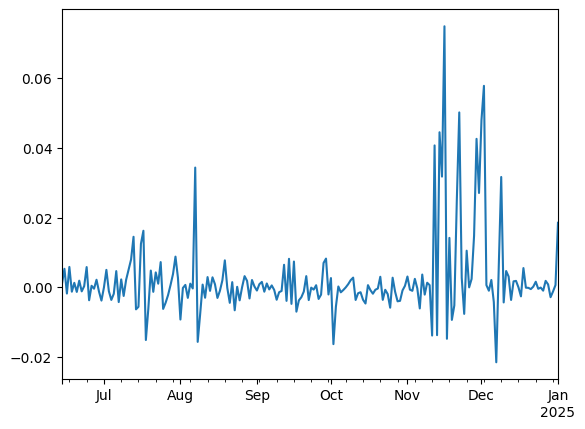

In [19]:
differenced_m_c_PW = multi_clopred_PW.copy()
for col in differenced_m_c_PW.columns:
    differenced_m_c_PW[col] = differenced_m_c_PW[col] - differenced_m_c_PW['0.25_2.0']

differenced_m_c_PW['0.0_1.0'].plot()

<Axes: >

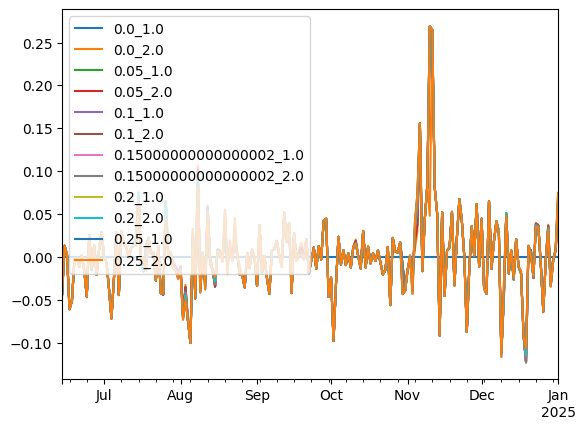

In [23]:

differenced_m_c_PW = multi_L_clopred_PW.copy()
for col in differenced_m_c_PW.columns:
    differenced_m_c_PW[col] = differenced_m_c_PW[col] - differenced_m_c_PW['0.0_1.0']

differenced_m_c_PW.plot()

HOW TO CREATE A MULTI-PORTFOLIO

The main requirement is you need the historical data of portfolios that are being balanced as part of the multi-portfolio.

So, you want return history for the portfolio, so you can calculate the mean and the standard deviation.

1. For each portfolio scheme, run it at least 90 times, and save the results.
2. Balance the meta-portfolio.


To make things simpler (possibly):
1. For each portfolio scheme, run it as many times as allowable all the way to the end.
2. Window the results.
3. Balance a meta-portfolio based on the results.

In [26]:
from itertools import product

# Portfolio schemes:
# window is 720, 240, 80, 30
# alpha is 0, 0.1, 0.5
# full prediction is yes or no
# 24 portfolios
WAF_list = list(product([720, 240, 80, 30], [0, 0.1, 0.5], [True, False]))

predictions_dfs = [
    pd.read_csv(f'./-for_optimization-/{tick}_Close_predictions.csv')[["Date", "Predicted"]].set_index('Date') for tick in tickers
]

collected_PR = pd.DataFrame(
    columns=[f"WAF_{window}_{alpha}_{full}" for window, alpha, full in WAF_list]
)

start_date = pd.Timestamp(START_DATE)
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    collected_PR.loc[current_date] = 0.0
    returns = []
    for window, alpha, full in WAF_list:
        # Filter data up to the current date
        opens = pd.concat([df["Open"] for df in dfs], axis=1)
        opens.columns = tickers
        data_up_to_today = opens.loc[:current_date]
        if len(data_up_to_today) > window:
            data_up_to_today = data_up_to_today.iloc[-window:]
        try:
            predictions = np.array([
                p_df.loc[str(current_date.date())].values for p_df in predictions_dfs
            ]).flatten()

            
            if not full:
                mean_prices = data_up_to_today.mean()
                enhanced_data = data_up_to_today.copy()
                enhanced_data.loc['predicted'] = (1 - alpha) * mean_prices + alpha * predictions

                # Calculate expected returns and covariance matrix using the latest data
                mean_returns = expected_returns.mean_historical_return(enhanced_data, frequency=365)
                cov_matrix = risk_models.sample_cov(enhanced_data)

                # Optimize for maximum Sharpe ratio
                ef = EfficientFrontier(mean_returns, cov_matrix)
                weights = ef.max_sharpe(risk_free_rate=-1)
                cleaned_weights = ef.clean_weights()
            else:
                predictions_dfs_indexed = [
                    p_df.set_index(pd.to_datetime(p_df.index)) for p_df in predictions_dfs
                ]
                all_predictions = [
                    p_df[p_df.index <= current_date].values for p_df in predictions_dfs_indexed
                ]
                all_predictions = [
                    x.flatten() for x in all_predictions
                ]
                min_length = min(len(arr) for arr in all_predictions)
                all_predictions = [arr[-min_length:] for arr in all_predictions]
                data_up_to_predstart = data_up_to_today[:-len(all_predictions) + 1]
                data_up_to_today.loc[current_date] = 0
                for all_prediction, i in zip(zip(*all_predictions), data_up_to_today.index[-len(all_predictions):]):
                    data_up_to_today.loc[i] = all_prediction

                # Calculate expected returns and covariance matrix using the latest data
                mean_returns = expected_returns.mean_historical_return(enhanced_data, frequency=365)
                cov_matrix = risk_models.sample_cov(enhanced_data)

                # Optimize for maximum Sharpe ratio
                ef = EfficientFrontier(mean_returns, cov_matrix)
                try:
                    weights = ef.max_sharpe(risk_free_rate=0.0001)
                    cleaned_weights = ef.clean_weights()
                except Exception:
                    print("Using previous weights")
                    previous_weights = collected_PR.loc[current_date - pd.Timedelta(days=1)]
                    cleaned_weights = dict(zip(collected_PR.columns, previous_weights))
        except KeyError:
            print("Couldn't find", str(current_date.date()))

        # Get returns for the current day (next day's returns based on today's weights)
        daily_returns = pd.DataFrame(
            {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
            index=[current_date]
        ).loc[current_date]

        # Calculate portfolio return using today's weights
        portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)
        returns.append(portfolio_return)
    collected_PR.loc[current_date] = pd.Series(returns, index=collected_PR.columns)


Using previous weights
Couldn't find 2024-06-14
Using previous weights
Couldn't find 2024-06-14
Using previous weights
Couldn't find 2024-06-14
Using previous weights
Couldn't find 2024-06-14
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Usi

c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previ

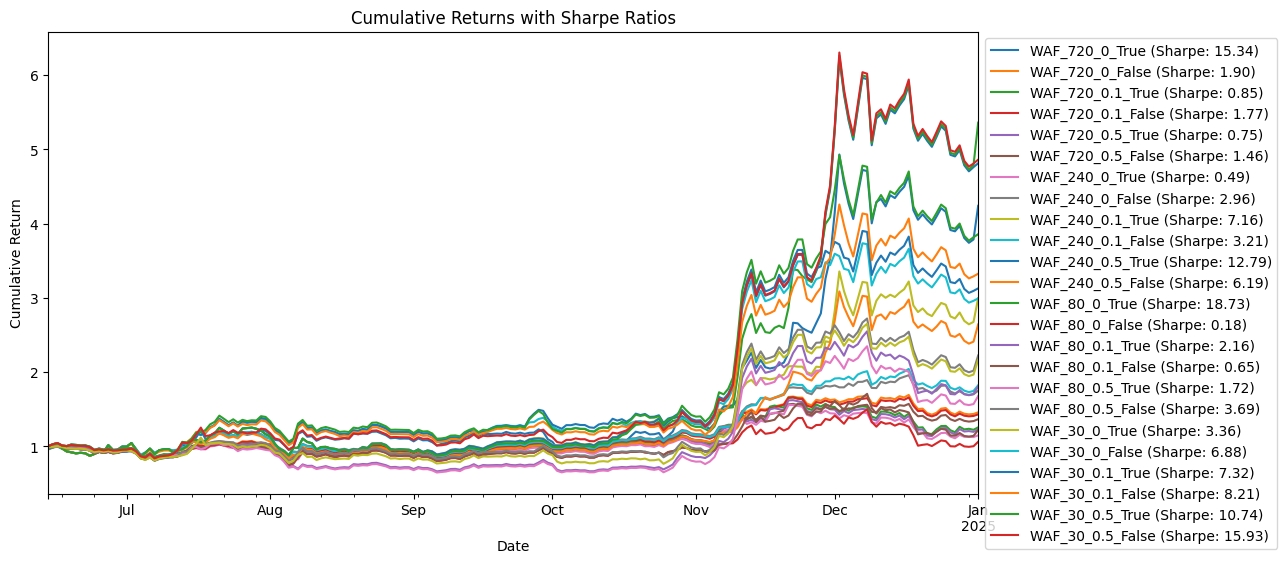

In [27]:
cumulative_returns = (1 + collected_PR).cumprod()
sharpe_ratios = cumulative_returns.apply(
    lambda x: (x.iloc[-1]**(365 / len(x)) - 1) / (x.pct_change().std() * np.sqrt(365))
)

ax = cumulative_returns.plot(figsize=(12, 6), title="Cumulative Returns with Sharpe Ratios")
for line, label in zip(ax.get_lines(), cumulative_returns.columns):
    sharpe_ratio = sharpe_ratios[label]
    line.set_label(f"{label} (Sharpe: {sharpe_ratio:.2f})")

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


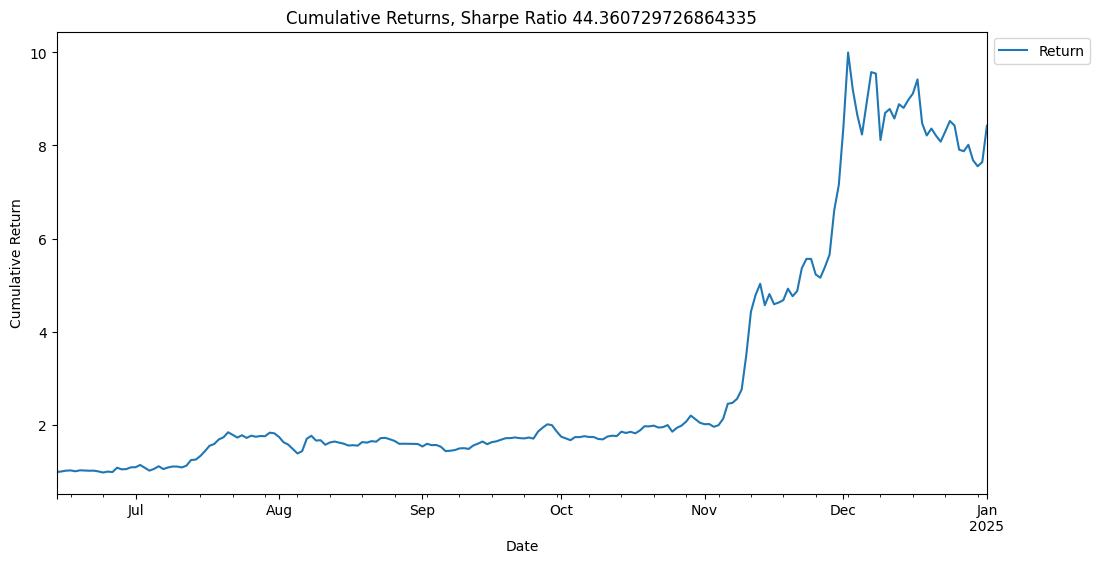

In [28]:
meta_portfolio_PW = pd.DataFrame(columns=[*collected_PR.columns, "Return"])


start_date = pd.Timestamp(START_DATE)
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    subset = collected_PR.loc[:current_date]
    result = collected_PR.loc[current_date]
    if len(subset) <= 3:
        cleaned_weights = [1 / len(collected_PR.columns)] * len(collected_PR.columns)
    else:
        # Filter data up to the current date
        opens = (1 + subset).cumprod()
        opens.columns = collected_PR.columns
        data_up_to_today = opens.loc[:current_date]

        # Calculate expected returns and covariance matrix using the latest data
        mean_returns = expected_returns.mean_historical_return(data_up_to_today, frequency=365)
        cov_matrix = risk_models.sample_cov(data_up_to_today)

        # Optimize for maximum Sharpe ratio
        ef = EfficientFrontier(mean_returns, cov_matrix)
        weights = ef.max_sharpe(risk_free_rate=-1)
        cleaned_weights = list(ef.clean_weights().values())

    # Calculate portfolio return using today's weights
    portfolio_return = np.dot(np.array(cleaned_weights), result.values)

    meta_portfolio_PW.loc[current_date] = 0.0
    meta_portfolio_PW.loc[current_date] = [*cleaned_weights, portfolio_return]



cumulative_returns = (1 + meta_portfolio_PW["Return"]).cumprod()
portfolio_annualized_return = cumulative_returns.iloc[-1]**(365 / len(portfolio_weights)) - 1
portfolio_annualized_volatility = meta_portfolio_PW["Return"].std() * np.sqrt(365)
sharpe_ratio = portfolio_annualized_return / portfolio_annualized_volatility

ax = cumulative_returns.plot(figsize=(12, 6), title=f"Cumulative Returns, Sharpe Ratio {sharpe_ratio}")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()



Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights
Using previous weights


c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


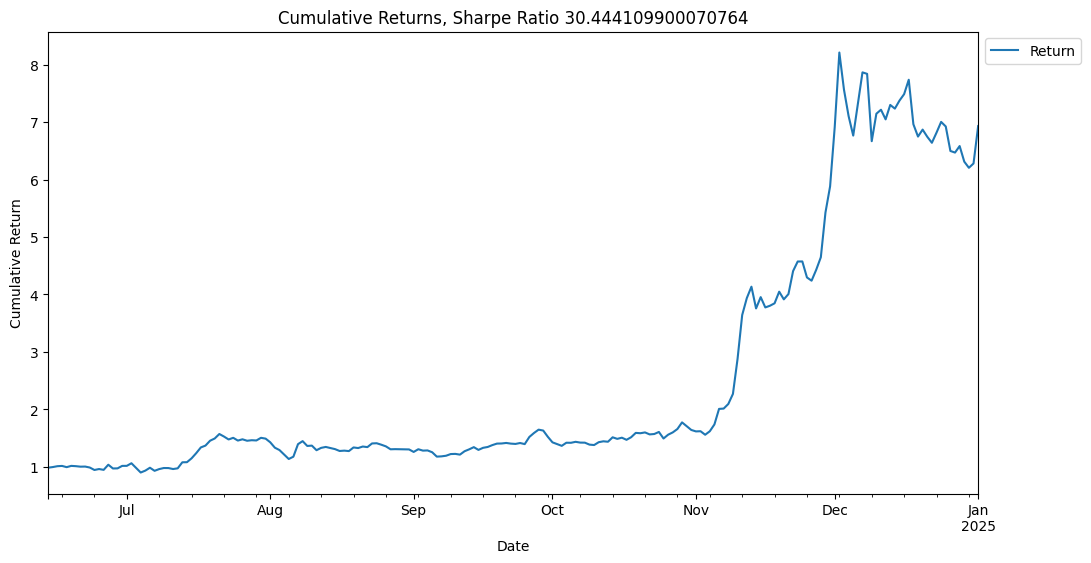

In [32]:
metastab_portfolio_PW = pd.DataFrame(columns=[*collected_PR.columns, "boring", "Return"])
collected_stable_PR = collected_PR.copy()
collected_stable_PR["boring"] = np.random.uniform(-0.1, 0, size=len(collected_stable_PR))

start_date = pd.Timestamp(START_DATE)
for current_date in dfs[-1].index[dfs[-1].index > start_date]:
    subset = collected_stable_PR.loc[:current_date]
    result = collected_stable_PR.loc[current_date]
    if len(subset) <= 3:
        cleaned_weights = [1 / len(collected_stable_PR.columns)] * len(collected_stable_PR.columns)
    else:
        # Filter data up to the current date
        opens = (1 + subset).cumprod()
        opens.columns = collected_stable_PR.columns
        data_up_to_today = opens.loc[:current_date]

        # Calculate expected returns and covariance matrix using the latest data
        mean_returns = expected_returns.mean_historical_return(data_up_to_today, frequency=365)
        cov_matrix = risk_models.sample_cov(data_up_to_today)

        # Optimize for maximum Sharpe ratio
        ef = EfficientFrontier(mean_returns, cov_matrix)
        try:
            weights = ef.max_sharpe(risk_free_rate=0.0001)
            cleaned_weights = list(ef.clean_weights().values())
        except Exception:
            print("Using previous weights")
            pass

    # Calculate portfolio return using today's weights
    portfolio_return = np.dot(np.array(cleaned_weights), result.values)

    metastab_portfolio_PW.loc[current_date] = 0.0
    metastab_portfolio_PW.loc[current_date] = [*cleaned_weights, portfolio_return]



cumulative_returns = (1 + metastab_portfolio_PW["Return"]).cumprod()
portfolio_annualized_return = cumulative_returns.iloc[-1]**(365 / len(portfolio_weights)) - 1
portfolio_annualized_volatility = metastab_portfolio_PW["Return"].std() * np.sqrt(365)
sharpe_ratio = portfolio_annualized_return / portfolio_annualized_volatility

ax = cumulative_returns.plot(figsize=(12, 6), title=f"Cumulative Returns, Sharpe Ratio {sharpe_ratio}")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()



In [34]:
from IPython import get_ipython

ipy = get_ipython()
for var in ipy.user_ns:
    if not var.startswith('_'):  # Skip private/internal variables
        try:
            ipy.run_line_magic('store', var)
        except Exception as e:
            print(f"Could not store variable {var}: {e}")

Stored 'In' (list)
Stored 'Out' (dict)
Stored 'get_ipython' (function)
Could not store variable exit: Can't pickle local object 'ScriptMagics._make_script_magic.<locals>.named_script_magic'
Could not store variable quit: Can't pickle local object 'ScriptMagics._make_script_magic.<locals>.named_script_magic'
Could not store variable open: Can't pickle <function open at 0x0000025D8DC82E80>: it's not the same object as io.open
Stored 'EfficientFrontier' (type)
Could not store variable risk_models: cannot pickle 'module' object
Could not store variable expected_returns: cannot pickle 'module' object
Could not store variable data: cannot pickle 'module' object
Could not store variable plt: cannot pickle 'module' object
Could not store variable np: cannot pickle 'module' object
Could not store variable pd: cannot pickle 'module' object
Stored 'tickers' (list)
Stored 'assets' (list)
Stored 'dfs' (list)
Stored 'df' (DataFrame)
Stored 'START_DATE' (str)
Stored 'test_dfs' (list)
Stored 'returns'

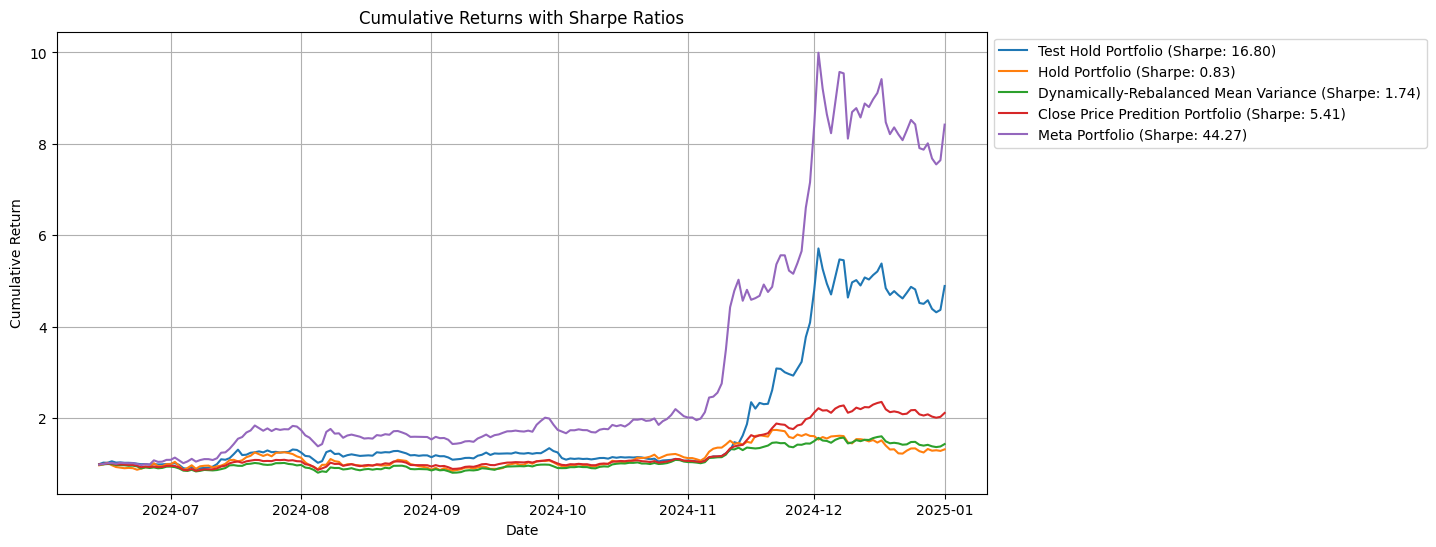

In [35]:
# display(test_hold_portfolio_weights)
# display(hold_portfolio_weights)
# display(portfolio_weights)
# display(Clopred_portfolio_weights)
# display(meta_portfolio_PW)

TH_Ret = (1 + test_hold_portfolio_weights["Return"]).cumprod()
H_Ret = (1 + hold_portfolio_weights["Return"]).cumprod()
PW_Ret = (1 + portfolio_weights["Return"]).cumprod()
CR_Ret = (1 + Clopred_portfolio_weights["Return"]).cumprod()
meta_Ret = (1 + meta_portfolio_PW["Return"]).cumprod()

# Plot cumulative returns with Sharpe ratios as labels
plt.figure(figsize=(12, 6))
# Recalculate Sharpe ratios
TH_sharpe = (TH_Ret.iloc[-1]**(365 / len(TH_Ret)) - 1) / (TH_Ret.pct_change().std() * np.sqrt(365))
H_sharpe = (H_Ret.iloc[-1]**(365 / len(H_Ret)) - 1) / (H_Ret.pct_change().std() * np.sqrt(365))
PW_sharpe = (PW_Ret.iloc[-1]**(365 / len(PW_Ret)) - 1) / (PW_Ret.pct_change().std() * np.sqrt(365))
CR_sharpe = (CR_Ret.iloc[-1]**(365 / len(CR_Ret)) - 1) / (CR_Ret.pct_change().std() * np.sqrt(365))
meta_sharpe = (meta_Ret.iloc[-1]**(365 / len(meta_Ret)) - 1) / (meta_Ret.pct_change().std() * np.sqrt(365))

# Plot cumulative returns with recalculated Sharpe ratios
plt.plot(TH_Ret, label=f"Test Hold Portfolio (Sharpe: {TH_sharpe:.2f})")
plt.plot(H_Ret, label=f"Hold Portfolio (Sharpe: {H_sharpe:.2f})")
plt.plot(PW_Ret, label=f"Dynamically-Rebalanced Mean Variance (Sharpe: {PW_sharpe:.2f})")
plt.plot(CR_Ret, label=f"Close Price Predition Portfolio (Sharpe: {CR_sharpe:.2f})")
plt.plot(meta_Ret, label=f"Meta Portfolio (Sharpe: {meta_sharpe:.2f})")

plt.title("Cumulative Returns with Sharpe Ratios")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.grid()
plt.show()

<Axes: >

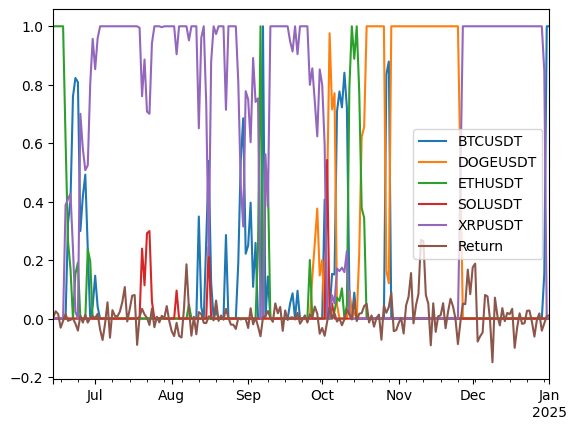

In [32]:
Clopred_portfolio_weights.plot()

In [25]:
# Define a dictionary to store metrics for each portfolio
portfolio_metrics = {
    "Portfolio": ["Test Hold", "Hold", "Dynamic MVO", "Close Prediction", "Meta"],
    "Cumulative Return": [
        (1 + test_hold_portfolio_weights["Return"]).cumprod().iloc[-1],
        (1 + hold_portfolio_weights["Return"]).cumprod().iloc[-1],
        (1 + portfolio_weights["Return"]).cumprod().iloc[-1],
        (1 + Clopred_portfolio_weights["Return"]).cumprod().iloc[-1],
        (1 + meta_portfolio_PW["Return"]).cumprod().iloc[-1],
    ],
    "Annualized Return": [
        (1 + test_hold_portfolio_weights["Return"]).cumprod().iloc[-1]**(365 / len(test_hold_portfolio_weights)) - 1,
        (1 + hold_portfolio_weights["Return"]).cumprod().iloc[-1]**(365 / len(hold_portfolio_weights)) - 1,
        (1 + portfolio_weights["Return"]).cumprod().iloc[-1]**(365 / len(portfolio_weights)) - 1,
        (1 + Clopred_portfolio_weights["Return"]).cumprod().iloc[-1]**(365 / len(Clopred_portfolio_weights)) - 1,
        (1 + meta_portfolio_PW["Return"]).cumprod().iloc[-1]**(365 / len(meta_portfolio_PW)) - 1,
    ],
    "Annualized Volatility": [
        test_hold_portfolio_weights["Return"].std() * np.sqrt(365),
        hold_portfolio_weights["Return"].std() * np.sqrt(365),
        portfolio_weights["Return"].std() * np.sqrt(365),
        Clopred_portfolio_weights["Return"].std() * np.sqrt(365),
        meta_portfolio_PW["Return"].std() * np.sqrt(365),
    ],
    "Sharpe Ratio": [
        ((1 + test_hold_portfolio_weights["Return"]).cumprod().iloc[-1]**(365 / len(test_hold_portfolio_weights)) - 1) / (test_hold_portfolio_weights["Return"].std() * np.sqrt(365)),
        ((1 + hold_portfolio_weights["Return"]).cumprod().iloc[-1]**(365 / len(hold_portfolio_weights)) - 1) / (hold_portfolio_weights["Return"].std() * np.sqrt(365)),
        ((1 + portfolio_weights["Return"]).cumprod().iloc[-1]**(365 / len(portfolio_weights)) - 1) / (portfolio_weights["Return"].std() * np.sqrt(365)),
        ((1 + Clopred_portfolio_weights["Return"]).cumprod().iloc[-1]**(365 / len(Clopred_portfolio_weights)) - 1) / (Clopred_portfolio_weights["Return"].std() * np.sqrt(365)),
        ((1 + meta_portfolio_PW["Return"]).cumprod().iloc[-1]**(365 / len(meta_portfolio_PW)) - 1) / (meta_portfolio_PW["Return"].std() * np.sqrt(365)),
    ],
}
portfolio_metrics["Maximum Drawdown"] = [
    (1 + test_hold_portfolio_weights["Return"]).cumprod().max() / (1 + test_hold_portfolio_weights["Return"]).cumprod().min() - 1,
    (1 + hold_portfolio_weights["Return"]).cumprod().max() / (1 + hold_portfolio_weights["Return"]).cumprod().min() - 1,
    (1 + portfolio_weights["Return"]).cumprod().max() / (1 + portfolio_weights["Return"]).cumprod().min() - 1,
    (1 + Clopred_portfolio_weights["Return"]).cumprod().max() / (1 + Clopred_portfolio_weights["Return"]).cumprod().min() - 1,
    (1 + meta_portfolio_PW["Return"]).cumprod().max() / (1 + meta_portfolio_PW["Return"]).cumprod().min() - 1,
]

portfolio_metrics["Calmar Ratio"] = [
    portfolio_metrics["Annualized Return"][i] / portfolio_metrics["Maximum Drawdown"][i] if portfolio_metrics["Maximum Drawdown"][i] != 0 else np.nan
    for i in range(len(portfolio_metrics["Portfolio"]))
]

portfolio_metrics["Sortino Ratio"] = [
    portfolio_metrics["Annualized Return"][i] / (
        test_hold_portfolio_weights["Return"][test_hold_portfolio_weights["Return"] < 0].std() * np.sqrt(365)
        if i == 0 else
        hold_portfolio_weights["Return"][hold_portfolio_weights["Return"] < 0].std() * np.sqrt(365)
        if i == 1 else
        portfolio_weights["Return"][portfolio_weights["Return"] < 0].std() * np.sqrt(365)
        if i == 2 else
        Clopred_portfolio_weights["Return"][Clopred_portfolio_weights["Return"] < 0].std() * np.sqrt(365)
        if i == 3 else
        meta_portfolio_PW["Return"][meta_portfolio_PW["Return"] < 0].std() * np.sqrt(365)
    )
    for i in range(len(portfolio_metrics["Portfolio"]))
]


# Create a DataFrame from the dictionary
portfolio_metrics_df = pd.DataFrame(portfolio_metrics)

# Display the DataFrame
portfolio_metrics_df

,Portfolio,Cumulative Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Maximum Drawdown,Calmar Ratio,Sortino Ratio
0,Test Hold,4.891592,16.611190,0.986739,16.834430,5.494636,3.023164,32.543915
1,Hold,1.319030,0.649271,0.779784,0.832630,1.054378,0.615786,1.480424
2,Dynamic MVO,1.474162,1.016275,0.508094,2.000169,1.043466,0.973941,3.362589
3,Close Prediction,1.553813,1.217401,0.490213,2.483413,1.066531,1.141459,4.104438
4,Meta,6.809570,31.017656,1.012959,30.620841,8.212141,3.777049,61.390731


<Axes: >

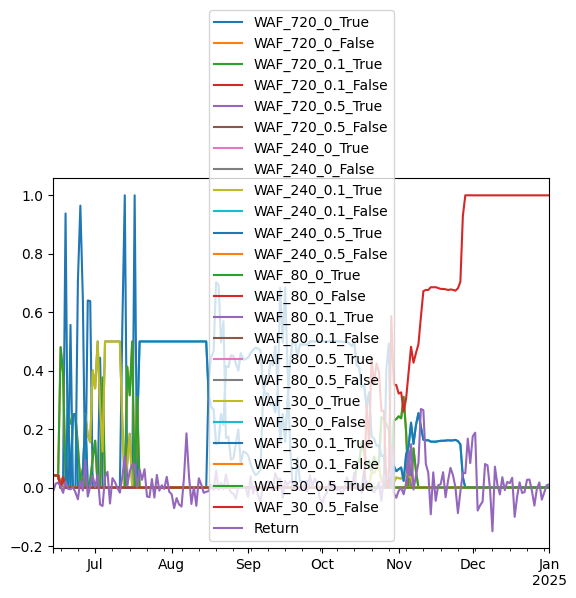

In [ ]:
meta_portfolio_PW.plot()